### SONG RECOMMENDATION SYSTEM (Machine Learning Project)
> Recommend songs on basis of the audio features using [Spotify's dataset](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing Libraries

Importing specific version of spotify for the API to work

In [ ]:
!pip install spotipy==2.16.1

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# spotify library for using Spotify Web API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler
import difflib
from tabulate import tabulate

from numpy import savetxt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Data fetching

Fetching the data from the dataset into variables

In [ ]:
path = "/content/drive/MyDrive/Machine Learning/data_by_year.csv"
path_2 = "/content/drive/MyDrive/Machine Learning/data.csv"
data_year = pd.read_csv(path,encoding="utf-8")
data = pd.read_csv(path_2,encoding="utf-8")

In [ ]:
data_year.head() # displaying the first 5 rows of the data (in this case this data is the grouped by year version of the original data)

,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,1920,0.631242,0.515750,238092.997135,0.418700,0.354219,0.216049,-12.654020,0.082984,113.226900,0.498210,0.610315,2,1
1,1921,0.862105,0.432171,257891.762821,0.241136,0.337158,0.205219,-16.811660,0.078952,102.425397,0.378276,0.391026,2,1
2,1922,0.828934,0.575620,140135.140496,0.226173,0.254776,0.256662,-20.840083,0.464368,100.033149,0.571190,0.090909,5,1
3,1923,0.957247,0.577341,177942.362162,0.262406,0.371733,0.227462,-14.129211,0.093949,114.010730,0.625492,5.205405,0,1
4,1924,0.940200,0.549894,191046.707627,0.344347,0.581701,0.235219,-14.231343,0.092089,120.689572,0.663725,0.661017,10,1


#### Data Visualisation w.r.t. year

Visualizing the trend of different audio features over the decades i.e. how the different audio features have changed over the decades thorugh which we can infer about the type of the songs which we currently hear.

In [ ]:
years = list(data_year["year"])
fig = go.Figure()
fig.add_trace(go.Scatter(x=years,y=data_year.energy,name="energy"))
fig.add_trace(go.Scatter(x=years,y=data_year.acousticness,name="acousticness"))
fig.add_trace(go.Scatter(x=years,y=data_year.danceability,name="dancebility"))
fig.add_trace(go.Scatter(x=years,y=data_year.valence,name="valence"))
fig.add_trace(go.Scatter(x=years,y=data_year.instrumentalness,name="intrumentalness"))
fig.add_trace(go.Scatter(x=years,y=data_year.liveness,name="liveness"))
fig.add_trace(go.Scatter(x=years,y=data_year.speechiness,name="speechiness"))
fig.add_trace(go.Scatter(x=years,y=data_year.valence,name="valence"))
fig.update_layout(xaxis_title="year")
fig.show()

#### Analysis of the whole dataset

In [ ]:
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


Dropping the columns **id**, **year**, **duration of the song** and the **realease date** of the songs. These are not the audio features and are also not the paramters which affects the similarity in different songs.

In [ ]:
data = data.drop(["id","year","duration_ms","release_date"], axis=1)

In [ ]:
data.head()

,acousticness,artists,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence
0,0.991000,['Mamie Smith'],0.598,0.224,0,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,0.0936,149.976,0.6340
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,0.517,0,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,0.0534,86.889,0.9500
2,0.993000,['Mamie Smith'],0.647,0.186,0,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,0.1740,97.600,0.6890
3,0.000173,['Oscar Velazquez'],0.730,0.798,0,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,0.0425,127.997,0.0422
4,0.295000,['Mixe'],0.704,0.707,1,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,0.0768,122.076,0.2990


Rearranging the data

In [ ]:
 data = data[['name','artists','explicit','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','popularity']]

In [ ]:
data.head()

,name,artists,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
0,Keep A Song In Your Soul,['Mamie Smith'],0,0.598,0.224,5,-12.628,0,0.0936,0.991000,0.000522,0.3790,0.6340,149.976,12
1,I Put A Spell On You,"[""Screamin' Jay Hawkins""]",0,0.852,0.517,5,-7.261,0,0.0534,0.643000,0.026400,0.0809,0.9500,86.889,7
2,Golfing Papa,['Mamie Smith'],0,0.647,0.186,0,-12.098,1,0.1740,0.993000,0.000018,0.5190,0.6890,97.600,4
3,True House Music - Xavier Santos & Carlos Gomi...,['Oscar Velazquez'],0,0.730,0.798,2,-7.311,1,0.0425,0.000173,0.801000,0.1280,0.0422,127.997,17
4,Xuniverxe,['Mixe'],1,0.704,0.707,10,-6.036,0,0.0768,0.295000,0.000246,0.4020,0.2990,122.076,2


Check for any null values present in the dataset or not!

In [ ]:
data.isnull().sum() # pre processing data to check if there is any missing value or not

name                0
artists             0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
popularity          0
dtype: int64

Dropping the column **popularity** as it was orginally not included in our hypothesis.

In [ ]:
data = data.drop(["popularity"], axis=1)

In [ ]:
data.head()

,name,artists,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Keep A Song In Your Soul,['Mamie Smith'],0,0.598,0.224,5,-12.628,0,0.0936,0.991000,0.000522,0.3790,0.6340,149.976
1,I Put A Spell On You,"[""Screamin' Jay Hawkins""]",0,0.852,0.517,5,-7.261,0,0.0534,0.643000,0.026400,0.0809,0.9500,86.889
2,Golfing Papa,['Mamie Smith'],0,0.647,0.186,0,-12.098,1,0.1740,0.993000,0.000018,0.5190,0.6890,97.600
3,True House Music - Xavier Santos & Carlos Gomi...,['Oscar Velazquez'],0,0.730,0.798,2,-7.311,1,0.0425,0.000173,0.801000,0.1280,0.0422,127.997
4,Xuniverxe,['Mixe'],1,0.704,0.707,10,-6.036,0,0.0768,0.295000,0.000246,0.4020,0.2990,122.076


Plotting the correlation matrix to quantify the correlattion of each feature with other features.

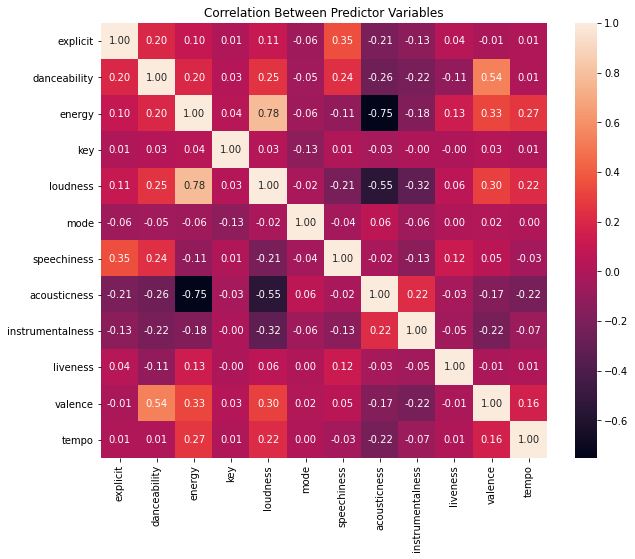

In [ ]:
correlation = data.corr()
plt.figure(figsize = (10, 8))
plt.title('Correlation Between Predictor Variables')
sns.heatmap(correlation, annot = True, fmt = '.2f')

Removing the loudness and energy column due to correlation with acoustissness, Here the threshold = $|0.5|$ is been considered as this means that the features are atleast $50\%$ correlated .

In [ ]:
data = data.drop(["energy","loudness"], axis=1)

In [ ]:
data.head()

,name,artists,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Keep A Song In Your Soul,['Mamie Smith'],0,0.598,5,0,0.0936,0.991000,0.000522,0.3790,0.6340,149.976
1,I Put A Spell On You,"[""Screamin' Jay Hawkins""]",0,0.852,5,0,0.0534,0.643000,0.026400,0.0809,0.9500,86.889
2,Golfing Papa,['Mamie Smith'],0,0.647,0,1,0.1740,0.993000,0.000018,0.5190,0.6890,97.600
3,True House Music - Xavier Santos & Carlos Gomi...,['Oscar Velazquez'],0,0.730,2,1,0.0425,0.000173,0.801000,0.1280,0.0422,127.997
4,Xuniverxe,['Mixe'],1,0.704,10,0,0.0768,0.295000,0.000246,0.4020,0.2990,122.076


In [ ]:
data.dtypes # displays the data type of each column

name                 object
artists              object
explicit              int64
danceability        float64
key                   int64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

Checking for the duplicate data in the dataset. The *data.duplicated()* method checks for the duplicate data and the returns the index of the duplicated data rows.

> Note : The *duplicated()* function will only say that the two columns are duplicat when all of the features have same value

In [ ]:
dupli = list(data[data.duplicated()].index) # finding the list of the index which are duplicate

In [ ]:
data_drop = data.drop(dupli,axis=0) # dropping all the duplicate rows

In [ ]:
data_drop.shape # The final shape of the dataset

(168097, 12)

In [ ]:
data = data_drop

In [ ]:
data = data.reset_index(drop=True) # reseting the index after the removing the duplicate data rows

**Save data to file**

In [ ]:
data.to_csv('/content/drive/MyDrive/Machine Learning/final_data.csv') # saving the final dataset 

Taking only the numerical values for the further analysis

In [ ]:
num_types = ['int64','float64']
num = data.select_dtypes(include=num_types)
num.head()

,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,0.598,5,0,0.0936,0.991000,0.000522,0.3790,0.6340,149.976
1,0,0.852,5,0,0.0534,0.643000,0.026400,0.0809,0.9500,86.889
2,0,0.647,0,1,0.1740,0.993000,0.000018,0.5190,0.6890,97.600
3,0,0.730,2,1,0.0425,0.000173,0.801000,0.1280,0.0422,127.997
4,1,0.704,10,0,0.0768,0.295000,0.000246,0.4020,0.2990,122.076


In [ ]:
num.describe().loc[['mean','std','min','max']].round(2) # finding the basic statistical values of the features

,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
mean,0.07,0.54,5.20,0.70,0.11,0.50,0.19,0.21,0.53,116.91
std,0.25,0.18,3.52,0.46,0.18,0.38,0.33,0.18,0.26,30.29
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,0.99,11.00,1.00,0.97,1.00,1.00,1.00,1.00,243.51


#### Elbow Method for find optimal $k$ for performing k means clustering algorithm

In [ ]:
def kmeans(num,k):
    '''
    Function for k means algorithm
    Paramters: num -> dataset and k-> the number of clusters
    Returns: the distortion value and the inertia value
    '''
    km = KMeans(n_clusters=k,random_state=0)
    clus = km.fit_predict(num)
    distortion = sum(np.min(cdist(num, km.cluster_centers_,'euclidean'), axis=1)) / num.shape[0]
    inertia = km.inertia_
    return distortion,inertia

Next step is the calculate the value of distortion and inertia for different values of $k$

In [ ]:
distortion = []
inertia = []
k = []
for i in range(8,13):
  dis,inert = kmeans(num,i)
  distortion.append(dis)
  inertia.append(inert)
  k.append(i)

In [ ]:
for i in range(13,20):
  dis,inert = kmeans(num,i)
  distortion.append(dis)
  inertia.append(inert)
  k.append(i)

In [ ]:
for i in range(7,3,-1):
  dis,inert = kmeans(num,i)
  distortion = [dis] + distortion
  inertia = [inert] + inertia
  k = [i] + k

Plotting the final graph of $Inertia$ vs $k$

Text(0, 0.5, 'Inertia')

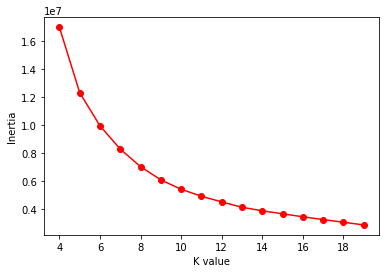

In [ ]:
plt.plot(k,inertia,'ro-')
plt.xlabel('K value')
plt.ylabel('Inertia')

From the above graph we can infer that the after $k=11$ the increase in number of clusters does not affect the inertia values much.

Plotting the graph of $distortion$ vs $k$

Text(0, 0.5, 'Distrotion')

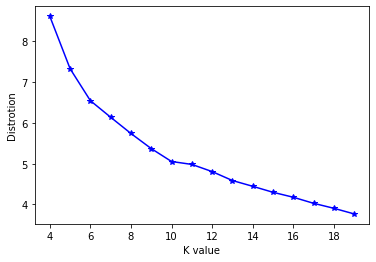

In [ ]:
plt.plot(k,distortion,'b*-')
plt.xlabel('K value')
plt.ylabel('Distrotion')

From the above graph we can infer that the after $k=11$ the increase in number of clusters does not affect the distortion values much.

After performing elbow method (calulating the distortion and inertia for different values of $k$), the optimal k value comes out to be $11$ which we infered from the above graphs

#### Performing K means for $k=11$ on data

The method used here is the inbuilt K means algorithm of *sklearn* python library

In [ ]:
optimal_cluster = 11 # final number of optimal clusters obtained from elbow method

km = KMeans(n_clusters=optimal_cluster) # Performing K means for k=11
cluster = km.fit_predict(num) # returns the cluster number for each row of the dataset

In [ ]:
cluster

array([5, 3, 4, ..., 1, 3, 4], dtype=int32)

In [ ]:
num.loc[:,('cluster')] = cluster # adding the cluster column to the dataset
num.shape

(168097, 11)

In [ ]:
centers_inbuiltkm = km.cluster_centers_ # The final cluster centers

**Saving Clustered Data and the centers to a csv file**

In [ ]:
num.to_csv("/content/drive/MyDrive/Machine Learning/final_clustered_data.csv")

In [ ]:
savetxt('/content/drive/MyDrive/Machine Learning/centers_inbuiltkm.csv',centers_inbuiltkm,delimiter=',')

#### Implementation of k means algorithm from scratch


The below implementation is of optimal k means algorithm. [Reference paper](https://ieeexplore.ieee.org/document/5453745)

In [ ]:
features = ["explicit","danceability","key","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo"]

def clus_dist_calc(data_row,centers):
    min_dist = 1e18
    cluster_no = -1
    cnt = 0
    
    for index,center in centers.iterrows():
      data_row = np.array(data_row).reshape(1,-1)
      center = np.array(center).reshape(1,-1)
      eucli_dist = cdist(data_row,center,'euclidean')
      eucli_dist = eucli_dist[0][0]
      if eucli_dist < min_dist:
        min_dist = eucli_dist
        cluster_no = cnt
      cnt+=1
    return cluster_no,min_dist


def kmeans(data,k):
  initial_centers = data.sample(n=k)
  
  CLUS = [0]*data.shape[0]
  DIST = [0]*data.shape[0]
  
  for index,data_row in data.iterrows():

    cluster_no,min_dist = clus_dist_calc(data_row,initial_centers)
    
    CLUS[index] = cluster_no
    DIST[index] = min_dist

  data['cluster'] = np.array(CLUS)
  data['distance'] = np.array(DIST)

  convergence = True
  new_clusters = None

  while convergence:

    convergence = False
    new_clusters = data.groupby(['cluster']).mean()[features]

    for index,data_row in data.iterrows():
      curr_clus = data_row.cluster
      curr_dist = data_row.distance

      feature_row = data_row[features]
      feature_row = np.array(feature_row).reshape(1,-1)

      curr_close_center = new_clusters.loc[curr_clus]
      curr_close_center = np.array(curr_close_center).reshape(1,-1)

      new_dist = cdist(feature_row,curr_close_center,'euclidean')
      new_dist = new_dist[0][0]
      
      epsilon = 0.00001
      if (new_dist-curr_dist) <= epsilon:
        continue
      else:
        convergence = True
        cluster_no,min_dist = clus_dist_calc(feature_row,new_clusters)
        CLUS[index] = cluster_no
        DIST[index] = min_dist

    data['cluster'] = np.array(CLUS)
    data['distance'] = np.array(DIST)

  return new_clusters

In [ ]:
man_num = num.drop(['cluster'],axis=1) 
centers = kmeans(man_num,11) # performing the manual k-means algorithm

In [ ]:
centers # Displaying the final centers

,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,,
0,0.051344,0.607037,5.376707,0.677091,0.096022,0.410392,0.211466,0.208813,0.558668,125.398019
1,0.053827,0.542878,5.592708,0.682995,0.086887,0.409629,0.225351,0.222407,0.522148,135.586702
2,0.063735,0.452386,4.809982,0.716091,0.134980,0.702796,0.258947,0.209445,0.407622,76.497617
3,0.106542,0.469922,6.222979,0.705950,0.133855,0.409213,0.145804,0.218124,0.561270,165.458324
4,0.081442,0.431112,5.015220,0.721228,0.118303,0.471308,0.154627,0.214105,0.555675,178.588450
5,0.073764,0.521694,5.230824,0.717862,0.089946,0.411039,0.156932,0.211604,0.558405,146.055641
6,0.062729,0.579766,5.753697,0.699968,0.098389,0.508625,0.167563,0.214447,0.551597,105.829313
7,0.046495,0.602528,3.994159,0.725584,0.092647,0.511485,0.179942,0.206529,0.576386,115.363604
8,0.101252,0.547904,5.607637,0.700929,0.112370,0.521528,0.161354,0.209853,0.524480,93.238811


In [ ]:
man_num.head()

,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster,distance
0,0,0.598,5,0,0.0936,0.991000,0.000522,0.3790,0.6340,149.976,5,11.804198
1,0,0.852,5,0,0.0534,0.643000,0.026400,0.0809,0.9500,86.889,8,7.019749
2,0,0.647,0,1,0.1740,0.993000,0.000018,0.5190,0.6890,97.600,8,7.997966
3,0,0.730,2,1,0.0425,0.000173,0.801000,0.1280,0.0422,127.997,0,5.054247
4,1,0.704,10,0,0.0768,0.295000,0.000246,0.4020,0.2990,122.076,0,6.985910


**Saving the clustered dataset and centers to a csv file**

In [ ]:
man_num.to_csv("/content/drive/MyDrive/Machine Learning/manual_clustered_data.csv")

In [ ]:
savetxt('/content/drive/MyDrive/Machine Learning/centers.csv',centers,delimiter=',')

Droping the distance which was initally used for the algorithm

In [ ]:
final_num = man_num.drop(['distance'],axis=1)

#### Re-reading the data previously stored in the csv format for recommendation system

In [ ]:
path = "/content/drive/MyDrive/Machine Learning/manual_clustered_data.csv"
path_2 = "/content/drive/MyDrive/Machine Learning/final_clustered_data.csv"
path_3 = "/content/drive/MyDrive/Machine Learning/final_data.csv"
path_4 = "/content/drive/MyDrive/Machine Learning/fuzzy_clustered_data.csv"
final_num = pd.read_csv(path,encoding="utf-8")
num = pd.read_csv(path_2,encoding="utf-8")
dset = pd.read_csv(path_4,encoding="utf-8")
data = pd.read_csv(path_3,encoding="utf-8")

In [ ]:
final_num.head()

,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0,0.598,5,0,0.0936,0.991000,0.000522,0.3790,0.6340,149.976,5
1,0,0.852,5,0,0.0534,0.643000,0.026400,0.0809,0.9500,86.889,8
2,0,0.647,0,1,0.1740,0.993000,0.000018,0.5190,0.6890,97.600,8
3,0,0.730,2,1,0.0425,0.000173,0.801000,0.1280,0.0422,127.997,0
4,1,0.704,10,0,0.0768,0.295000,0.000246,0.4020,0.2990,122.076,0


In [ ]:
num.head()

,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0,0.598,5,0,0.0936,0.991000,0.000522,0.3790,0.6340,149.976,8
1,0,0.852,5,0,0.0534,0.643000,0.026400,0.0809,0.9500,86.889,2
2,0,0.647,0,1,0.1740,0.993000,0.000018,0.5190,0.6890,97.600,2
3,0,0.730,2,1,0.0425,0.000173,0.801000,0.1280,0.0422,127.997,4
4,1,0.704,10,0,0.0768,0.295000,0.000246,0.4020,0.2990,122.076,4


In [ ]:
dset.head()

,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0,0.598,5,0,0.0936,0.991000,0.000522,0.3790,0.6340,149.976,6
1,0,0.852,5,0,0.0534,0.643000,0.026400,0.0809,0.9500,86.889,4
2,0,0.647,0,1,0.1740,0.993000,0.000018,0.5190,0.6890,97.600,10
3,0,0.730,2,1,0.0425,0.000173,0.801000,0.1280,0.0422,127.997,7
4,1,0.704,10,0,0.0768,0.295000,0.000246,0.4020,0.2990,122.076,5


In [ ]:
final_num.drop(final_num.columns[0],axis=1,inplace=True)
num.drop(num.columns[0],axis=1,inplace=True)
data.drop(data.columns[0],axis=1,inplace=True)
dset.drop(dset.columns[0],axis=1,inplace=True)
final_num.drop(["distance"],axis=1,inplace=True)

In [ ]:
data.head()

,name,artists,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Keep A Song In Your Soul,['Mamie Smith'],0,0.598,5,0,0.0936,0.991000,0.000522,0.3790,0.6340,149.976
1,I Put A Spell On You,"[""Screamin' Jay Hawkins""]",0,0.852,5,0,0.0534,0.643000,0.026400,0.0809,0.9500,86.889
2,Golfing Papa,['Mamie Smith'],0,0.647,0,1,0.1740,0.993000,0.000018,0.5190,0.6890,97.600
3,True House Music - Xavier Santos & Carlos Gomi...,['Oscar Velazquez'],0,0.730,2,1,0.0425,0.000173,0.801000,0.1280,0.0422,127.997
4,Xuniverxe,['Mixe'],1,0.704,10,0,0.0768,0.295000,0.000246,0.4020,0.2990,122.076


In [ ]:
from numpy import genfromtxt
from tabulate import tabulate
features = ["explicit","danceability","key","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo"]
centers = genfromtxt('/content/drive/MyDrive/Machine Learning/centers.csv', delimiter=',')
centers_inbuiltkm = genfromtxt('/content/drive/MyDrive/Machine Learning/centers_inbuiltkm.csv', delimiter=',')
fccenters = genfromtxt('/content/drive/MyDrive/Machine Learning/fuzzy_centers.csv', delimiter=',')
print(tabulate(centers, features, tablefmt="fancy_grid"))
print(tabulate(centers_inbuiltkm, features, tablefmt="fancy_grid"))
print(tabulate(fccenters, features, tablefmt="fancy_grid"))

╒════════════╤════════════════╤═════════╤══════════╤═══════════════╤════════════════╤════════════════════╤════════════╤═══════════╤══════════╕
│   explicit │   danceability │     key │     mode │   speechiness │   acousticness │   instrumentalness │   liveness │   valence │    tempo │
╞════════════╪════════════════╪═════════╪══════════╪═══════════════╪════════════════╪════════════════════╪════════════╪═══════════╪══════════╡
│  0.051344  │       0.607037 │ 5.37671 │ 0.677091 │     0.0960224 │       0.410392 │           0.211466 │   0.208813 │  0.558668 │ 125.398  │
├────────────┼────────────────┼─────────┼──────────┼───────────────┼────────────────┼────────────────────┼────────────┼───────────┼──────────┤
│  0.0538269 │       0.542878 │ 5.59271 │ 0.682995 │     0.0868869 │       0.409629 │           0.225351 │   0.222407 │  0.522148 │ 135.587  │
├────────────┼────────────────┼─────────┼──────────┼───────────────┼────────────────┼────────────────────┼────────────┼───────────┼──────────┤

#### Recommendation System

##### Recommendation System Functions

Initialising the Spotify API with the credentials

In [ ]:
cid = ''
secret = ''

ccm = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(auth_manager=ccm)

In [ ]:
# function made just for print in a pretty way
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

In [ ]:
# A function for returning the required audio features from the Spotify using Spotify's Web API
nott = ["type","id","uri","track_href","analysis_url","time_signature","energy","loudness","duration_ms"]
def song_attr(name,artist):
    song_data = []
    results = sp.search(q= 'track: {} artist: {}'.format(name,artist), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]
   
    song_data.append(int(results['explicit']))

    for key, value in audio_features.items():
        if key not in nott:
          song_data.append(value)

    song_data = np.array(song_data)
    song_data = song_data.reshape(1,-1)
    if song_data.shape[1]!=10 or song_data.shape[0]!=1 or song_data is None:
      raise TypeError("Thullu")
    return song_data

In [ ]:
# A fucntion made for general use giving all the details of the song
def find_song_det(name,artist):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} artist: {}'.format(name,artist), limit=1)
    if results['tracks']['items'] == []:
        return "Duh"

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]
    pretty(results)
    print(audio_features)

In [ ]:
def cal_song_edist(song,artist,data,centers):  
  '''
  Calculates the euclidean distance from the song to the data points of the cluster whose cluster center is nearest to that of the song
  Parameters: song -> song name, artist-> artist name, data-> the dataset, centers -> cluster centers obtained after
  Returns: sorted list of euclidean distance
  '''
  scenter = song_attr(song,artist)
  distances = cdist(scenter, centers, 'euclidean')

  mx = 1e18

  for i in range(len(distances[0])):

    if distances[0][i]<mx:
      mx = distances[0][i]
      center_ind = i

  print(f"Cluster #{center_ind}")
  
  resp_cluster = data.loc[data['cluster']==center_ind]
  rc = resp_cluster.drop(['cluster'],axis=1)
  
  edist = []
  index = []
  for ind,row in rc.iterrows():
      row = np.array(row).reshape(1,-1)
      eudist = cdist(row,scenter,'euclidean')
      eudist = eudist[0][0]
      edist.append((eudist,ind))
  edist.sort()
  return edist

Calculating the average of *pairwise cosine similarity* value from the recommendations

In [ ]:
def cosim(A,B):
  return np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))

In [ ]:
features = ["explicit","danceability","key","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo"]
def avg_cosim(A,B):
  B = B[features]
  sum = 0
  cnt = 0
  for index,datarow in B.iterrows():
    datarow = np.array(datarow)
    # datarow = datarow.reshape(1,-1)
    # print(cosim(A,datarow))
    csim = cosim(A,datarow)
    if csim<1:
      sum += csim
      cnt +=1
  return sum/cnt

In [ ]:
def recommend_songs(sys="Manual"):
  '''
  The final recommendation system based on the user input of song, its artist and number of songs to be recommended
  Parameters: type-> "Manual" will use the centers & clusters obtained after performing manual k means algorithm
                  -> "Inbuilt" will use the centers & clusters obtained after performing inbuilt k means algorithm
  Return: The number of recommended songs provided by the user.
  '''  
  songs = []
  while True:
    song = input("Enter a song name : ")
    artist = input("Enter artist names of the song entered (',' seperated if > 1) : ").split(',')
    songs.append([song,artist])
    cond = input("Add More ? (Y/N) : ")
    if cond == "N" or cond == "n":
      break
  n_songs = int(input("Number of songs to be recommended for each song : "))
  indexes = []
  ind = []
  dataset = None
  cent = None
  if sys=="Manual":
    dataset = final_num
    cent = centers
  elif sys=="Inbuilt":
    dataset = num
    cent = centers_inbuiltkm
  else:
    dataset = dset
    cent = fccenters
    

  for song,artist in songs:
    edist = cal_song_edist(song,artist,dataset,cent)
    indexes.append(edist)

  ind_sof = []
  cosinesim = []
  for i in range(len(indexes)):
    temp = indexes[i]
    temp.sort()
    temp = list(map(lambda x:x[1],temp))
    k = 0
    part_rec = []
    for j in temp:     
      if j not in ind_sof and k<min(len(temp),n_songs):
        ind_sof.append(j)
        part_rec.append(j)
        k += 1
    sim =avg_cosim(song_attr(songs[i][0],songs[i][1]),data.loc[part_rec])
    cosinesim.append(sim)

  avg_cosine_sim = sum(cosinesim)/len(cosinesim)
  print(f"Avg. cosine similarity : {avg_cosine_sim}")

  return data.loc[ind_sof]

#### Examples of the final recommendation system

In [ ]:
recommend_songs()

Enter a song name : Perfect
Enter artist names of the song entered (',' seperated if > 1) : Ed Sheeran
Add More ? (Y/N) : N
Number of songs to be recommended for each song : 3
Cluster #8
Avg. cosine similarity : [0.99999825]


,name,artists,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
18808,Perfect,['Ed Sheeran'],0,0.599,8,1,0.0232,0.1630,0.000000,0.1060,0.168,95.050
88401,Wasted,['Carrie Underwood'],0,0.548,8,1,0.0306,0.0936,0.000000,0.0721,0.311,94.998
99923,All Through the Night,['Cyndi Lauper'],0,0.576,8,1,0.0252,0.2130,0.000001,0.0619,0.340,95.100


In [ ]:
recommend_songs()

Enter a song name : lovely
Enter artist names of the song entered (',' seperated if > 1) : 
Add More ? (Y/N) : N
Number of songs to be recommended for each song : 3
Cluster #7
Avg. cosine similarity : [0.9999992]


,name,artists,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
18980,lovely (with Khalid),"['Billie Eilish', 'Khalid']",0,0.351,4,0,0.0333,0.934,0.0000,0.095,0.120,115.284
46672,The Christmas Song,['Herb Alpert & The Tijuana Brass'],0,0.439,4,0,0.0428,0.985,0.0221,0.102,0.143,115.194
66536,"The Nutcracker Suite, Op. 71a, TH 35: IIb. Dan...","['Pyotr Ilyich Tchaikovsky', 'Claudio Abbado',...",0,0.196,4,0,0.0349,0.876,0.0427,0.127,0.117,115.546


In [ ]:
recommend_songs(sys="Inbuilt")

Enter a song name : Perfect
Enter artist names of the song entered (',' seperated if > 1) : Ed Sheeran
Add More ? (Y/N) : N
Number of songs to be recommended for each song : 3
Cluster #2
Avg. cosine similarity : [0.99999825]


,name,artists,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
18808,Perfect,['Ed Sheeran'],0,0.599,8,1,0.0232,0.1630,0.000000,0.1060,0.168,95.050
88401,Wasted,['Carrie Underwood'],0,0.548,8,1,0.0306,0.0936,0.000000,0.0721,0.311,94.998
99923,All Through the Night,['Cyndi Lauper'],0,0.576,8,1,0.0252,0.2130,0.000001,0.0619,0.340,95.100


In [ ]:
recommend_songs(sys="Inbuilt")

Enter a song name : lovely
Enter artist names of the song entered (',' seperated if > 1) : 
Add More ? (Y/N) : N
Number of songs to be recommended for each song : 3
Cluster #10
Avg. cosine similarity : [0.9999992]


,name,artists,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
18980,lovely (with Khalid),"['Billie Eilish', 'Khalid']",0,0.351,4,0,0.0333,0.934,0.0000,0.095,0.120,115.284
46672,The Christmas Song,['Herb Alpert & The Tijuana Brass'],0,0.439,4,0,0.0428,0.985,0.0221,0.102,0.143,115.194
66536,"The Nutcracker Suite, Op. 71a, TH 35: IIb. Dan...","['Pyotr Ilyich Tchaikovsky', 'Claudio Abbado',...",0,0.196,4,0,0.0349,0.876,0.0427,0.127,0.117,115.546


In [ ]:
recommend_songs(sys="Fuzzy-C")

Enter a song name : Perfect
Enter artist names of the song entered (',' seperated if > 1) : Ed Sheeran
Add More ? (Y/N) : N
Number of songs to be recommended for each song : 3
Cluster #4
Avg. cosine similarity : [0.99999825]


,name,artists,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
18808,Perfect,['Ed Sheeran'],0,0.599,8,1,0.0232,0.1630,0.000000,0.1060,0.168,95.050
88401,Wasted,['Carrie Underwood'],0,0.548,8,1,0.0306,0.0936,0.000000,0.0721,0.311,94.998
99923,All Through the Night,['Cyndi Lauper'],0,0.576,8,1,0.0252,0.2130,0.000001,0.0619,0.340,95.100


In [ ]:
recommend_songs(sys="Fuzzy-C")

Enter a song name : lovely
Enter artist names of the song entered (',' seperated if > 1) : 
Add More ? (Y/N) : N
Number of songs to be recommended for each song : 3
Cluster #3
Avg. cosine similarity : [0.9999992]


,name,artists,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
18980,lovely (with Khalid),"['Billie Eilish', 'Khalid']",0,0.351,4,0,0.0333,0.934,0.0000,0.095,0.120,115.284
46672,The Christmas Song,['Herb Alpert & The Tijuana Brass'],0,0.439,4,0,0.0428,0.985,0.0221,0.102,0.143,115.194
66536,"The Nutcracker Suite, Op. 71a, TH 35: IIb. Dan...","['Pyotr Ilyich Tchaikovsky', 'Claudio Abbado',...",0,0.196,4,0,0.0349,0.876,0.0427,0.127,0.117,115.546


In [ ]:
recommend_songs()

Enter a song name : Often
Enter artist names of the song entered (',' seperated if > 1) : 
Add More ? (Y/N) : Y
Enter a song name : sobeautiful
Enter artist names of the song entered (',' seperated if > 1) : 
Add More ? (Y/N) : N
Number of songs to be recommended for each song : 2
Cluster #1
Cluster #1
Avg. cosine similarity : [0.9999843]


,name,artists,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
18462,Often,['The Weeknd'],1,0.572,7,0,0.0476,0.2220,0.0,0.1350,0.0713,134.078
54380,sobeautiful,['Musiq Soulchild'],0,0.689,7,0,0.0637,0.0656,0.0,0.0885,0.2100,133.987
34114,Un Siglo Sin Ti,['Chayanne'],0,0.611,7,0,0.0279,0.0961,0.0,0.1290,0.2610,133.906
15880,Brand New Year 2021,['Nikky Philip'],0,0.556,7,0,0.0306,0.0026,0.0,0.3800,0.3650,134.024


In [ ]:
recommend_songs()

Enter a song name : 7 Rings
Enter artist names of the song entered (',' seperated if > 1) : 
Add More ? (Y/N) : Y
Enter a song name : Perfect
Enter artist names of the song entered (',' seperated if > 1) : Ed Sheeran
Add More ? (Y/N) : N
Number of songs to be recommended for each song : 3
Cluster #1
Cluster #8
Avg. cosine similarity : [0.99999742]


,name,artists,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
19201,7 rings,['Ariana Grande'],1,0.778,1,0,0.3340,0.5920,0.000000,0.0881,0.327,140.048
106400,idfc - Tarro Remix,"['blackbear', 'Tarro']",1,0.580,1,0,0.2210,0.4810,0.000001,0.1090,0.389,139.751
19350,Lemonade,"['Internet Money', 'Gunna', 'Don Toliver', 'NAV']",1,0.799,1,0,0.0790,0.2560,0.000000,0.1110,0.471,140.040
18808,Perfect,['Ed Sheeran'],0,0.599,8,1,0.0232,0.1630,0.000000,0.1060,0.168,95.050
88401,Wasted,['Carrie Underwood'],0,0.548,8,1,0.0306,0.0936,0.000000,0.0721,0.311,94.998
99923,All Through the Night,['Cyndi Lauper'],0,0.576,8,1,0.0252,0.2130,0.000001,0.0619,0.340,95.100


### Fuzzy-C means clustering

In [ ]:
pip install fuzzy-c-means

In [ ]:
from fcmeans import FCM

dset = num.drop(['cluster'],axis=1)
dset = dset.to_numpy()

Performing Fuzzy C clustering algorithm for number of clusters = 11 as there was not any proper method for finding optimal clusters so we went for the $11$.

In [ ]:
fc = FCM(n_clusters=11)
fc.fit(dset)
fcclusters = fc.predict(dset)

In [ ]:
fcclusters = fcclusters.reshape(-1,1)
fcclusters.shape
fcclusters = np.array(fcclusters)
dset = num.drop(['cluster'],axis=1)
dset['cluster'] = fcclusters

In [ ]:
fccenters = fc.centers

In [ ]:
features = ["explicit","danceability","key","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo"]
fccenters = pd.DataFrame(fccenters,columns = features)

In [ ]:
fccenters = fccenters.to_numpy()

Saving the clustered dataset and the center to the csv file

In [ ]:
dset.to_csv("/content/drive/MyDrive/Machine Learning/fuzzy_clustered_data.csv")

In [ ]:
savetxt('/content/drive/MyDrive/Machine Learning/fuzzy_centers.csv',fccenters,delimiter=',')

### Distortion calculation for different clustering

Calculating the $distortion$ for **inbuilt k-means**, **manual k-means** and **fuzzy c** clustering algorithms. $Distortion$ is the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used, same is implemented her.

In [ ]:
distortion = sum(np.min(cdist(num.drop(['cluster'],axis=1), centers_inbuiltkm,'euclidean'), axis=1)) / num.shape[0]

In [ ]:
distortion_m = sum(np.min(cdist(final_num.drop(['cluster'],axis=1), centers,'euclidean'), axis=1)) / final_num.shape[0]

In [ ]:
distortion_f = sum(np.min(cdist(dset.drop(['cluster'],axis=1), fccenters,'euclidean'), axis=1)) / dset.shape[0]

In [ ]:
print(f"Inbuilt : {distortion} \nManual  : {distortion_m}\nFuzzy   : {distortion_f}\n\n")

Inbuilt : 4.982472236273906 
Manual  : 5.105233896714533
Fuzzy   : 4.79627679773015




In [ ]:
import plotly.express as px
df = pd.DataFrame({"method":["Inbuilt","Manual","Fuzzy-C"], "distortion":[distortion,distortion_m,distortion_f]})
fig = px.bar(df, x='method', y='distortion')
fig.update_layout(autosize=False,width=500,height=500,font=dict(size=16,color="black"))
fig.show()